Сборный проект 2

Описание проекта:

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 
У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Описание данных:

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

# Импортирую все зависимости

In [1]:
!pip install matplotlib==3.5.0

     |████████████████████████████████| 11.2 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 1.2 MB/s  eta 0:00:01
     |████████████████████████████████| 4.6 MB 57.2 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4


In [2]:
!pip show matplotlib

Name: matplotlib
Version: 3.5.0
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /opt/conda/lib/python3.9/site-packages
Requires: fonttools, kiwisolver, pillow, numpy, python-dateutil, setuptools-scm, packaging, pyparsing, cycler
Required-by: seaborn, pyod, catboost


In [3]:
!pip install phik

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01


In [4]:
!pip install shap

     |████████████████████████████████| 539 kB 1.2 MB/s eta 0:00:01


In [5]:
pip install --upgrade scikit-learn

     |████████████████████████████████| 13.4 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 103.5 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import sklearn 

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder  
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, make_scorer, mean_absolute_percentage_error
import phik
import shap
from phik import phik_matrix
from shap import LinearExplainer

In [7]:
#Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

#### Задача 1: предсказание уровня удовлетворённости сотрудника

##### Загрузка данных

In [8]:
train_job = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_job.name = 'train_job_satisfaction_rate'

test_features = pd.read_csv('/datasets/test_features.csv')
test_features.name = 'test_features'

test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
test_target.name = 'test_target_job_satisfaction_rate'

Вывод шага:

Импортированы необходимые библиотеки для выполнения задачи.
- Файл train_job_satisfaction_rate.csv был успешно загружен и сохранен как train_job.
- Файл test_features.csv был успешно загружен и сохранен как test_features.
- Файл test_target_job_satisfaction_rate.csv был успешно загружен и сохранен как test_target.

##### Предобработка данных

Изучите данные и сделайте выводы. При необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

In [9]:
#создам фунцию для обзора содержимого в датафреймах
def describe_df(df):

    binary_feats = [col for col in df.columns if df[col].nunique() <= 2]
    categorical_feats = [col for col in df.columns if df[col].dtype == 'object' and col not in binary_feats]
    continuous_feats = [col for col in df.columns if df[col].dtype != 'object' and col not in binary_feats]

    print('DataFrame Name:', df.name, '\n')
    print('Binary Features:', binary_feats)
    print('Categorical Features:', categorical_feats)
    print('Continuous Features:', continuous_feats, '\n')

    print('Number of features:', df.shape[1])
    print('Number of rows:', df.shape[0], '\n')
    
    print('Missing Data:\n')
    print(df.isna().sum(),'\n')
    print('Duplicates:', df.duplicated().sum(),'\n')
    print(f'\nData Types: \n{df.dtypes}')

    print('Summary:\n')
    display(df.describe())
    print()

    print('Dataframe Head\n')
    display(df.head())
    print()
    print('Dataframe Tail\n')
    display(df.tail())

In [10]:
describe_df(train_job)

DataFrame Name: train_job_satisfaction_rate 

Binary Features: ['last_year_promo', 'last_year_violations']
Categorical Features: ['dept', 'level', 'workload']
Continuous Features: ['id', 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'] 

Number of features: 10
Number of rows: 4000 

Missing Data:

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64 

Duplicates: 0 


Data Types: 
id                         int64
dept                      object
level                     object
workload                  object
employment_years           int64
last_year_promo           object
last_year_violations      object
supervisor_evaluation      int64
salary                     int64
job_satisfaction_rate    float64
dtype: object
Summary:



,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000



Dataframe Head



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



Dataframe Tail



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48
3999,338347,technology,middle,medium,5,no,yes,1,44400,0.18


In [11]:
#посмотрю уникльные значение встолбце workload
train_job.workload.unique()

array(['medium', 'high', 'low'], dtype=object)

In [12]:
#посмотрю уникльные значение встолбце level
train_job.level.unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [13]:
#исправлю ошибку в значении senior
train_job.level = train_job.level.replace('sinior', 'senior')
train_job.level.unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [14]:
#проведу фильтрацию и проверю в каких строках имеется NaN
display(train_job[train_job.level.isnull()])
train_job[train_job.dept.isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [15]:
#создам новый датафрейм без столбца job_satisfaction_rate 
train_job_no_rate = train_job.drop(columns=('job_satisfaction_rate'))
train_job_no_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   3994 non-null   object
 2   level                  3996 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 281.4+ KB


In [16]:
describe_df(test_features)

DataFrame Name: test_features 

Binary Features: ['last_year_promo', 'last_year_violations']
Categorical Features: ['dept', 'level', 'workload']
Continuous Features: ['id', 'employment_years', 'supervisor_evaluation', 'salary'] 

Number of features: 9
Number of rows: 2000 

Missing Data:

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64 

Duplicates: 0 


Data Types: 
id                        int64
dept                     object
level                    object
workload                 object
employment_years          int64
last_year_promo          object
last_year_violations     object
supervisor_evaluation     int64
salary                    int64
dtype: object
Summary:



,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000



Dataframe Head



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



Dataframe Tail



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400
1999,771859,purchasing,middle,medium,1,no,no,4,38400


In [17]:
test_features.level.unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [18]:
test_features.level = test_features.level.replace('sinior', 'senior')
test_features.level.unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [19]:
test_features.workload.unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [20]:
display(test_features[test_features.level.isnull()])
test_features[test_features.dept.isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [21]:
#выявлю наиболее часто встречающееся значение с помошью моды
mode_dept_test_feat = test_features.dept.mode()[0]
mode_dept_test_feat

'sales'

In [22]:
#определю стоблцы с пропущенными значениями
null_cols = ['level', 'dept']

#создам пайплайн для их заполнения модой
null_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

#создам пайплайн для энкодирования категориальных переменных 
encoding_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'
)),
    ('encoder', OneHotEncoder(handle_unknown='ignore')
    )
])


In [23]:
#создам ColumnTransformer для обработки только указанных столбцов
change_nulls = ColumnTransformer(
    [('null', null_pipe, null_cols)],
    remainder='passthrough',
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
)

#обучу ColumnTransformer на данных train_job_no_rate
change_nulls.fit(train_job_no_rate)

# Применяем ColumnTransformer к train_job_no_rate и создаем новый DataFrame
train_job_no_rate_df = pd.DataFrame(
    change_nulls.transform(train_job_no_rate),
    columns=change_nulls.get_feature_names_out()
)

#применю ColumnTransformer к данным test_features и создаем новый DataFrame
test_features_df = pd.DataFrame(
    change_nulls.transform(test_features),
    columns=change_nulls.get_feature_names_out()
)

In [24]:
#вывод информации до и после обработки
print('До обработки:')
print('train level:', train_job_no_rate['level'].unique())
print('isna level:', train_job_no_rate['level'].isna().sum())
print('train dept:', train_job_no_rate['dept'].unique())
print('isna dept:', train_job_no_rate['dept'].isna().sum())
print()

#для train_job_no_rate_df
print('После обработки (train_job_no_rate):')
encoded_level_cols = [col for col in train_job_no_rate_df.columns if col.startswith('level_')]
encoded_dept_cols = [col for col in train_job_no_rate_df.columns if col.startswith('dept_')]

print('transformed level:', train_job_no_rate_df[encoded_level_cols].columns)
print('isna transformed level:', train_job_no_rate_df[encoded_level_cols].isna().sum().sum())
print('transformed dept:', train_job_no_rate_df[encoded_dept_cols].columns)
print('isna transformed dept:', train_job_no_rate_df[encoded_dept_cols].isna().sum().sum())
print()

#для test_features_df
print('После обработки (test_features):')
encoded_level_cols = [col for col in test_features_df.columns if col.startswith('level_')]
encoded_dept_cols = [col for col in test_features_df.columns if col.startswith('dept_')]

print('transformed level:', test_features_df[encoded_level_cols].columns)
print('isna transformed level:', test_features_df[encoded_level_cols].isna().sum().sum())
print('transformed dept:', test_features_df[encoded_dept_cols].columns)
print('isna transformed dept:', test_features_df[encoded_dept_cols].isna().sum().sum())

До обработки:
train level: ['junior' 'middle' 'senior' nan]
isna level: 4
train dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
isna dept: 6

После обработки (train_job_no_rate):
transformed level: Index([], dtype='object')
isna transformed level: 0.0
transformed dept: Index([], dtype='object')
isna transformed dept: 0.0

После обработки (test_features):
transformed level: Index([], dtype='object')
isna transformed level: 0.0
transformed dept: Index([], dtype='object')
isna transformed dept: 0.0


In [25]:
train_job_no_rate_df.info()
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   level                  4000 non-null   object
 1   dept                   4000 non-null   object
 2   id                     4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   object
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   object
 8   salary                 4000 non-null   object
dtypes: object(9)
memory usage: 281.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   level                  2000 non-null   object
 1   dept                   2000

In [26]:
#сравню списки 
feat_columns = [
    "level",
    "dept",
    "id",
    "workload",
    "employment_years",
    "last_year_promo",
    "last_year_violations",
    "supervisor_evaluation",
    "salary"
]

train_columns = [
    "level",
    "dept",
    "id",
    "workload",
    "employment_years",
    "last_year_promo",
    "last_year_violations",
    "supervisor_evaluation",
    "salary"
]

if train_columns == feat_columns:
    print("Одинаково")
else:
    print("Различаются")

Одинаково


In [27]:
#создам датафреймы со столбцами, которые перечислены в списках
train_job_no_rate_df = train_job_no_rate_df[train_columns]
test_features_df = test_features_df[feat_columns]

In [28]:
train_job_no_rate_df.level = train_job_no_rate_df.level.replace('sinior', 'senior')

In [29]:
#преобразую столбцы в целочисленный тип данных
train_cols_to_convert = ['id', 'employment_years', 'salary']
train_job_no_rate_df[train_cols_to_convert] = train_job_no_rate_df[train_cols_to_convert].astype(int)

In [30]:
train_job_no_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   level                  4000 non-null   object
 1   dept                   4000 non-null   object
 2   id                     4000 non-null   int64 
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   object
 8   salary                 4000 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 281.4+ KB


In [31]:
#проверю наличие стоблца job_satisfaction_rate в в датафрейме, в случае его остуствия - добавлю:
if 'job_satisfaction_rate' not in train_job_no_rate_df.columns:
    train_job_no_rate_df = train_job_no_rate_df.merge(
        train_job[
            ['id', 'job_satisfaction_rate']], on='id', how='left')
    train_job_no_rate_df.info()
else:
    print("Cтолбец id уже имеется в датафрейме:")
    print()
    train_job_no_rate_df.info()


train_job_final = train_job_no_rate_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   level                  4000 non-null   object 
 1   dept                   4000 non-null   object 
 2   id                     4000 non-null   int64  
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   object 
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 343.8+ KB


In [32]:
#преобразую столбцы в целочисленный тип данных
test_feat = ['id', 'employment_years', 'salary']
test_features_df[test_feat] = test_features_df[test_feat].astype(int)

In [33]:
#объединение данных по столбцу id
test_job_feat = pd.merge(test_features_df, test_target, on='id', how='inner')
test_job_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   level                  2000 non-null   object 
 1   dept                   2000 non-null   object 
 2   id                     2000 non-null   int64  
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   object 
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 171.9+ KB


In [34]:
#заменю пустые значения в столбце 'workload' на 'medium'
if ' ' in test_job_feat['workload'].unique():
    print("Столбец 'workload' содержит пробелы")
else:
    print("Столбец 'workload' не содержит пробелы")

test_job_feat['workload'] = test_job_feat['workload'].replace(' ', 'medium')

Столбец 'workload' содержит пробелы


Вывод:
- train_job

были обранужены пропущенные значения типа NaN. Столбец job_satisfaction_rate в датафрейме train_job был исключен перед предобработкой данных, и датафрейм был переименован как train_job_df. В столбце level значения sinior были изменены на senior. Пустые значения в столбцах level и dept  были заполнены с использованием пайплайна, согласно условиям задачи. Обработаннй датафрейм был переименован в train_job_df

- test_features

были обранужены пропущенные значения типа NaN. В столбце level значения sinior были изменены на senior. В столбце dept значение ' ' было изменено на моду sales. Пустые значения в столбцах level и dept  были заполнены с использованием пайплайна, согласно условиям задачи. Обработаннй датафрейм был переименован в test_features_df.

- test_target

Замечаний по наличию данных нет. Датафреймы был объединен с использованием функции merge по признаку id и получен новый датафрейм test_job_feat.

Столбцы id, employment_years и salary в датафрейме test_features_df были приведены к целочисленному типу данных (int).


##### Исследовательский анализ данных

Исследуйте все признаки и сделайте выводы о том, как их нужно подготовить.

In [35]:
#удаление столбца id
train_job_df_no_id = train_job_final.drop(columns='id')
train_job_df_no_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   level                  4000 non-null   object 
 1   dept                   4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   object 
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(2), object(6)
memory usage: 312.5+ KB


In [36]:
test_features_df_no_id = test_job_feat.drop(columns='id')
test_features_df_no_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   level                  2000 non-null   object 
 1   dept                   2000 non-null   object 
 2   workload               2000 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   object 
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(2), object(6)
memory usage: 156.2+ KB


In [37]:
#создам датафрейм имеющий только эти столбцы
train_job_df_no_id_cols = [
    'salary',
    'job_satisfaction_rate'
]

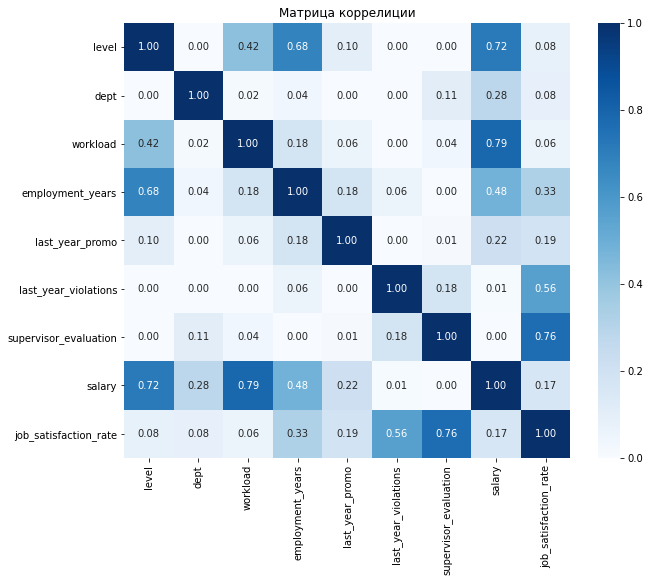

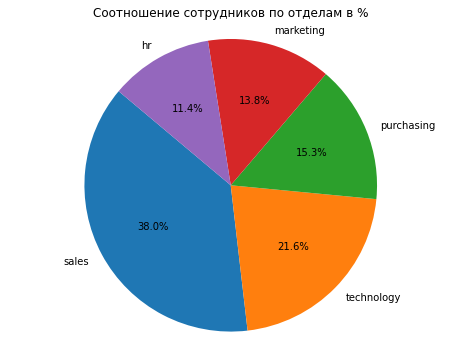

In [38]:
#вычислю матрицу корреляции 
train_job_df_no_id_phik = train_job_df_no_id.phik_matrix(interval_cols=train_job_df_no_id_cols)

#и построю ее
plt.figure(figsize=(10, 8))
sns.heatmap(train_job_df_no_id_phik, annot=True, cmap='Blues', fmt='.2f')
plt.title("Матрица коррелиции")
plt.show()


#вычислю кол-во сотрудников по отделам (в %)
train_dept_counts = train_job_df_no_id.dept.value_counts()

#построю круговую диаграмму
plt.figure(figsize=(8, 6))
plt.pie(train_dept_counts, labels=train_dept_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Соотношение сотрудников по отделам в %')
plt.show()

In [39]:
#создам датафрейм имеющий только эти столбцы
test_features_df_no_id_interval_cols = [
    'employment_years',
    'supervisor_evaluation',
    'salary'
]

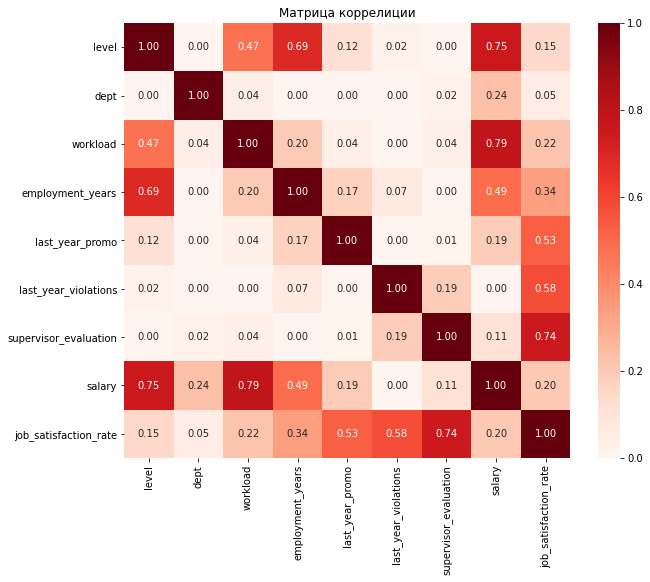

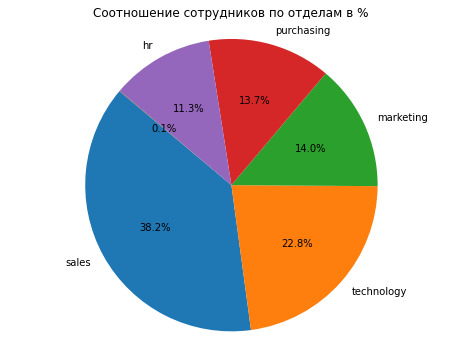

In [40]:
#вычислю матрицу корреляции и построю её
test_features_df_no_id_phik = test_features_df_no_id.phik_matrix(interval_cols=test_features_df_no_id_interval_cols)

plt.figure(figsize=(10, 8))
sns.heatmap(test_features_df_no_id_phik, annot=True, cmap='Reds', fmt='.2f')
plt.title("Матрица коррелиции")
plt.show()


#вычислю кол-во сотрудников по отделам (в %) и построю круговую диагрумму
test_features_counts = test_features_df_no_id.dept.value_counts()

plt.figure(figsize=(8, 6))
plt.pie(test_features_counts, labels=test_features_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Соотношение сотрудников по отделам в %')
plt.show()

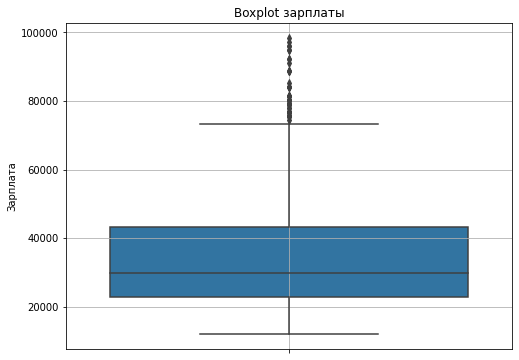

In [41]:
#создам boxplot для столбца salary
plt.figure(figsize=(8, 6))
sns.boxplot(y=train_job_df_no_id.salary)
plt.title('Boxplot зарплаты')
plt.ylabel('Зарплата')
plt.grid(True)
plt.show()

In [42]:
#создам датафрейм без столбцов employment_years и supervisor_evaluation
no_discrete_train_job_df_no_id = train_job_df_no_id.drop(
    columns=(
        ['employment_years', 'supervisor_evaluation']))

In [43]:
#функция для построения гистограммы распределения значений признака
def plot_histogram(data, feature_name, dataset_name):
    plt.figure(figsize=(8, 6))
    plt.hist(data[feature_name], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Распределение в {feature_name} в {dataset_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

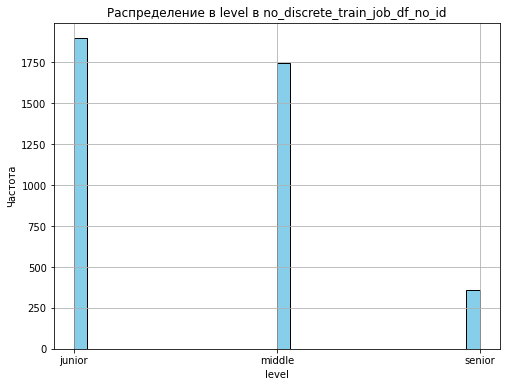

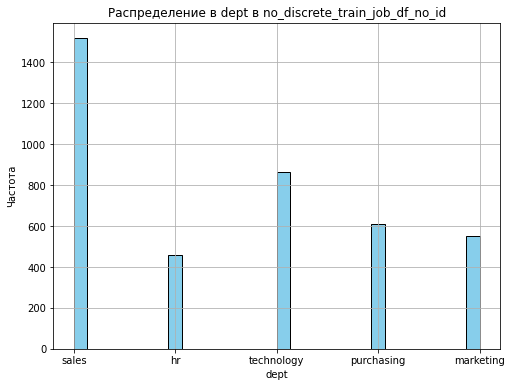

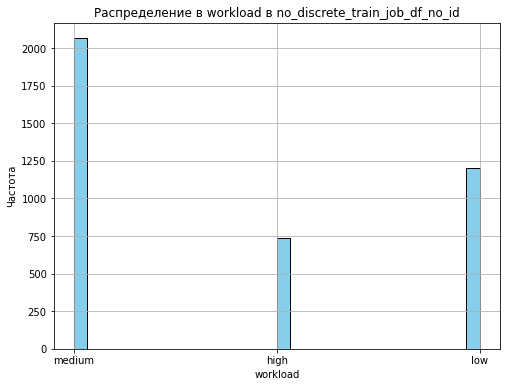

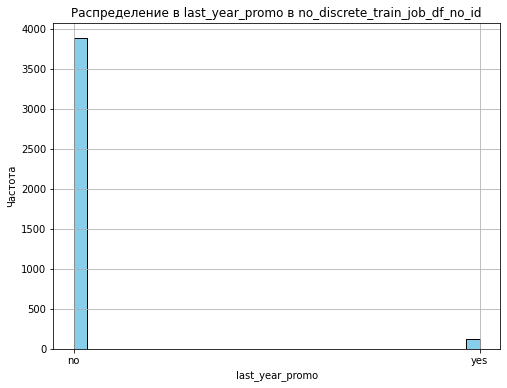

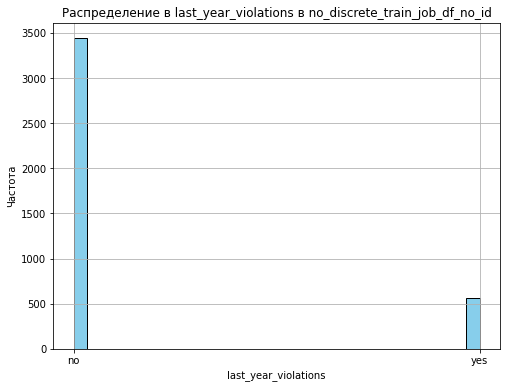

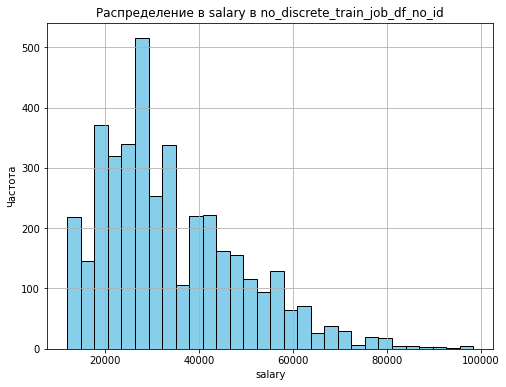

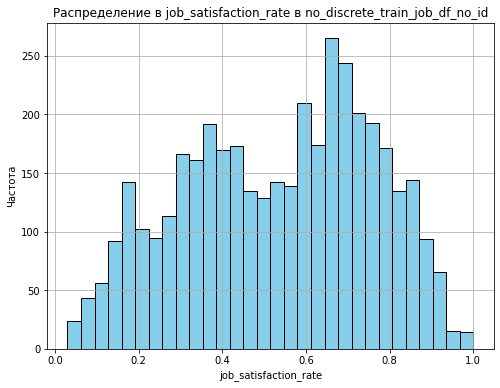

In [44]:
#построение гистограмм для каждого признака в train_job_df_no_id
for column in no_discrete_train_job_df_no_id.columns:
    plot_histogram(no_discrete_train_job_df_no_id, column, 'no_discrete_train_job_df_no_id')

In [45]:
discrete_train_job_df_cols = ['employment_years', 'supervisor_evaluation']

In [46]:
# Функция для построения countplot для определенного признака
def plot_countplot(data, feature_names, dataset_name):
    for feature_name in feature_names:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=data, x=feature_name, color='skyblue')
        plt.title(f'Распределение уникальных значений в {feature_name} в {dataset_name}')
        plt.xlabel(feature_name)
        plt.ylabel('Частота')
        plt.grid(True)
        plt.show()

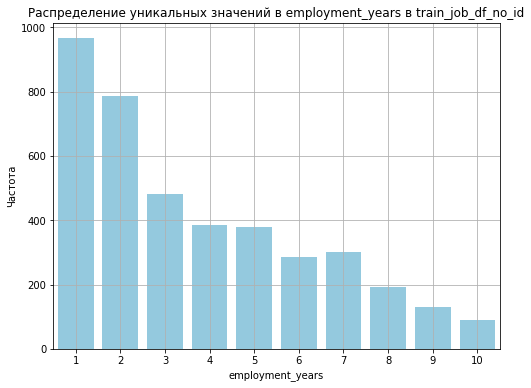

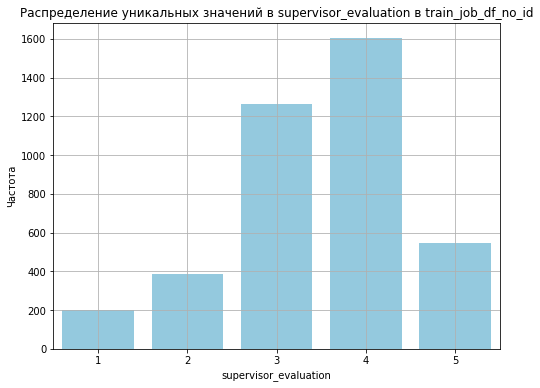

In [47]:
plot_countplot(train_job_df_no_id, discrete_train_job_df_cols, 'train_job_df_no_id')

In [48]:
no_discrete_test_features_df_no_id = test_features_df_no_id.drop(
    columns=(
        ['employment_years', 'supervisor_evaluation']))

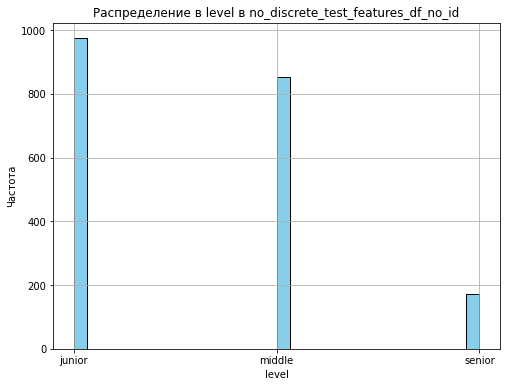

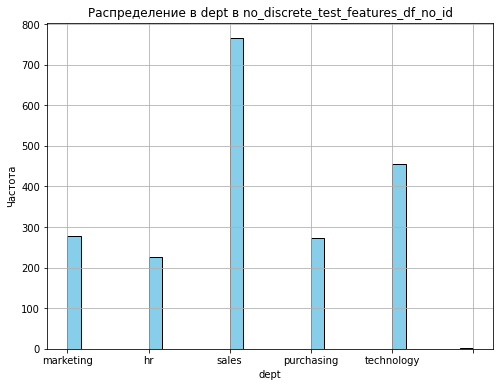

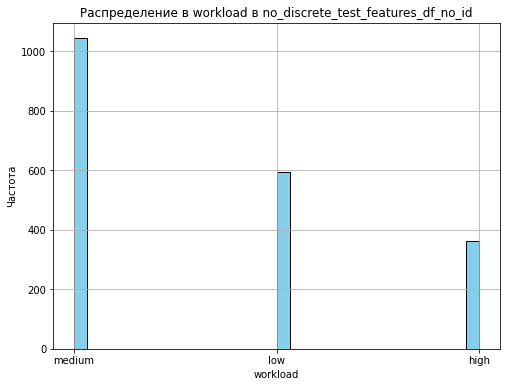

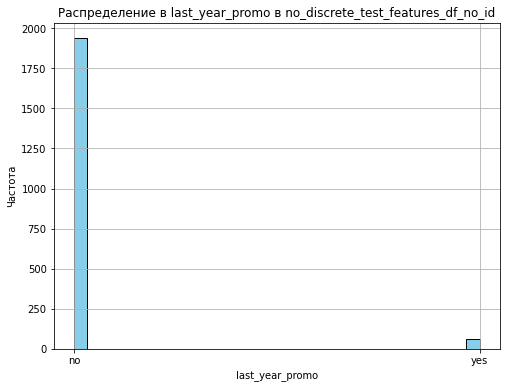

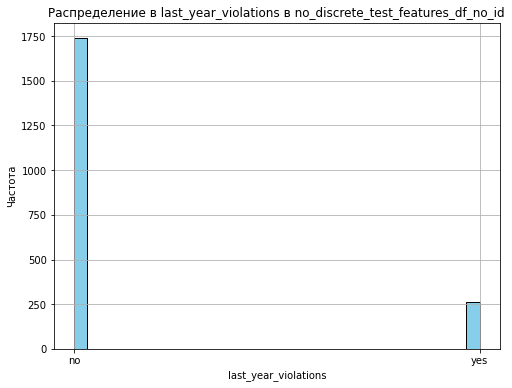

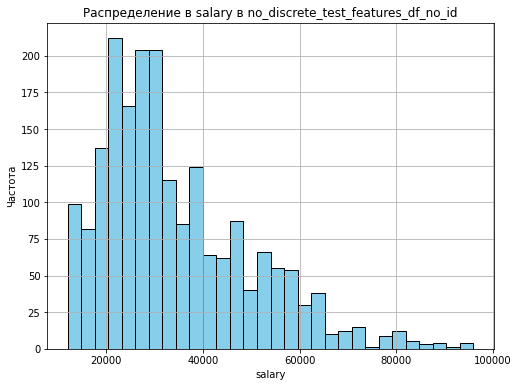

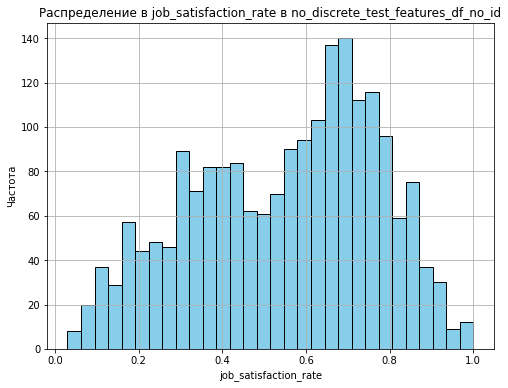

In [49]:
# Построение гистограмм для каждого признака в test_features_df_no_id
for column in no_discrete_test_features_df_no_id.columns:
    plot_histogram(
        no_discrete_test_features_df_no_id,
        column,
        'no_discrete_test_features_df_no_id'
    )

In [50]:
discrete_test_features_df_no_id = ['employment_years', 'supervisor_evaluation']

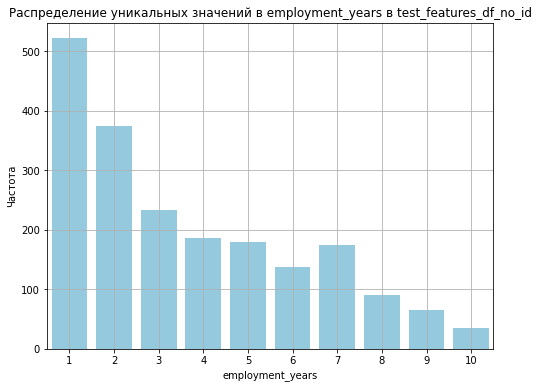

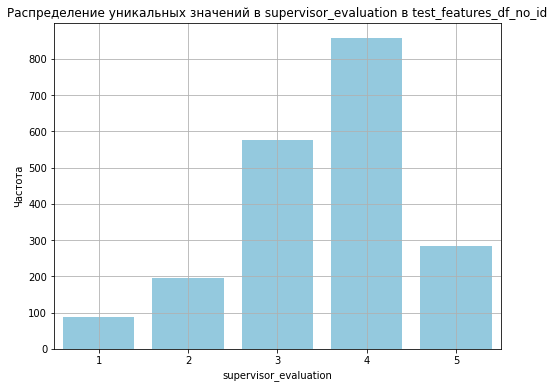

In [51]:
plot_countplot(test_features_df_no_id, discrete_test_features_df_no_id, 'test_features_df_no_id')

Вывод:

В датафрейме train_job_final все столбцы,кроме id, прошли корреляционный анализ, мультиколлинеарности нет. Я построила круговую диаграмма на основе данных из датафрейма, отображая процентное соотношение количества сотрудников по отделам.

В датафрейме test_features_df все столбцы,кроме id, прошли корреляционный анализ, мультиколлинеарности нет. Я построила круговую диаграмма на основе данных из датафрейма, отображая процентное соотношение количества сотрудников по отделам.

После построения boxplot для salary в датафрейме train_job_df_no_id были обнаружены выбросы. Исходя из анализа графика распределения в датафрейме train_job_df_no_id, были выявлены следующие данные:

Отдел с наибольшим числом сотрудников - sales;
Наиболее распространённый уровень сотрудников - junior;
Наиболее часто встречаемый уровень нагрузки - medium;
За последний год повышение получили более 1000 сотрудников из 4000;
Более 550 сотрудников из 4000 нарушили трудовой договор за последний год;
Распределение зарплаты имеет нормальную форму, с асимметрией влево;
В распределение уровня удовлетворённости сотрудников работой в компании имеется два  пика.

Исходя из анализа графика распределения в датафрейме train_job_df_no_id, были выявлены следующие данные:

В столбце employment_years наибольшее количество сотрудников отработало 1 год, а наименьшее количество — 10 лет. Значения между ними также увеличиваются по мере увеличения времени работы. В столбце supervisor_evaluation чаще всего встречается оценка 4, что указывает на высокую оценку качества работы сотрудников.

Исходя из анализа графика распределения в датафрейме test_features_df_no_id, было выявлено, что данные идентичны как указано ранее, кроме следующих данных:
В столбце "last_year_promo" наблюдается до 100 значений, а в столбце "last_year_violations" количество нарушений составляет чуть больше 250.

Из анализа графиков дискретных значений датафрейма test_features_df_no_id понятно, что распределение данных идентично с распределение дискретных значений датафрейма train_job_df_no_id

##### Подготовка данных

Подготовку признаков выполните в пайплайне, дополнив пайплайн шага предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

In [52]:
#проверю на наличие дубликатов в столбце id
train_job_final_id_duplicated = train_job_final.id.duplicated().any()

if train_job_final_id_duplicated:
    print("В столбце 'id' есть дубликаты.")
else:
    print("В столбце 'id' нет дубликатов.")

В столбце 'id' нет дубликатов.


In [53]:
#проверю наличие дубликатов в датафрейме, за исключением столбца id
duplicates_train_job_final_no_id = train_job_df_no_id[train_job_df_no_id.duplicated()]

if duplicates_train_job_final_no_id.empty:
    print("Дубликаты не найдены.")
else:
    print("Найдены дубликаты:")
    display(duplicates_train_job_final_no_id.count())

Найдены дубликаты:


level                    248
dept                     248
workload                 248
employment_years         248
last_year_promo          248
last_year_violations     248
supervisor_evaluation    248
salary                   248
job_satisfaction_rate    248
dtype: int64

In [54]:
#удалю дубликаты
train_job_df_no_id = train_job_df_no_id.drop_duplicates()
print("Дубликаты удалены.")

#вывод размера датафрейма после удаления дубликатов
print("Размер датафрейма после удаления дубликатов:", train_job_df_no_id.shape)

#вывод итогового датафрейма без дубликатов
print("Итоговый DataFrame без дубликатов:")
display(train_job_df_no_id)

Дубликаты удалены.
Размер датафрейма после удаления дубликатов: (3752, 9)
Итоговый DataFrame без дубликатов:


,level,dept,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,junior,sales,medium,2,no,no,1,24000,0.58
1,junior,hr,high,2,no,no,5,38400,0.76
2,junior,sales,low,1,no,no,2,12000,0.11
3,junior,technology,low,4,no,no,2,18000,0.37
4,junior,hr,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...
3993,senior,hr,high,6,no,no,4,80400,0.88
3994,junior,sales,medium,2,no,no,3,20400,0.27
3997,middle,sales,low,7,no,no,5,24000,0.76
3998,junior,sales,medium,2,no,no,3,24000,0.48


In [55]:
#разделение данных на признаки и целевую переменную для тренировочного набора
X_train = train_job_final.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_final["job_satisfaction_rate"]

#разделение данных на признаки и целевую переменную для тестового набора
X_test = test_job_feat.drop(['job_satisfaction_rate'], axis=1)
y_test = test_job_feat['job_satisfaction_rate']

#объединяю X_train и y_train для удаления дубликатов
train_combined = pd.concat([X_train, y_train], axis=1)

#удаляю дубликаты
train_combined = train_combined.drop_duplicates()

#разделяю обратно на X_train и y_train
X_train = train_combined.drop(['job_satisfaction_rate'], axis=1)
y_train = train_combined['job_satisfaction_rate']

#вывод размеров тренировочных и тестовых наборов
print("Размер X_train:", X_train.shape)
print("Размер y_train:", y_train.shape)
print("Размер X_test:", X_test.shape)
print("Размер y_test:", y_test.shape)

Размер X_train: (4000, 9)
Размер y_train: (4000,)
Размер X_test: (2000, 9)
Размер y_test: (2000,)


In [56]:
ohe_columns_1 = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns_1 = ['level', 'workload']
num_columns_1 = ['employment_years', 'supervisor_evaluation', 'salary']

In [57]:
#cоздание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_columns_1),
        ('ord', Pipeline([
            ('ordinal', OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['medium', 'high', 'low']
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )),
            ('imputer', SimpleImputer(strategy='most_frequent'))  #импутер для заполнения пропусков
        ]), ord_columns_1),
        ('scaler', StandardScaler(), num_columns_1),
    ],
    remainder='passthrough',
    force_int_remainder_cols=False 
)

Вывод:

Признаки и целевая переменная для обучающего и тестового наборов данных разделены.
- Созданы шаги для предобработки данных в пайплайне:

Для категориальных признаков использованы кодировщики OneHotEncoder и OrdinalEncoder с соответствующими параметрами.
Для числовых признаков применено масштабирование с помощью StandardScaler.
Все преобразования объединены в ColumnTransformer.

- Построен пайплайн для предобработки данных:

Преобразования данных объединены в пайплайн Pipeline с преобразователем preprocessor.
- Применена предобработка данных к обучающему и тестовому наборам:

Применен пайплайн к обучающим данным методом fit_transform и к тестовым данным методом transform.
- Обработаны отсутствующие значения в одном из признаков:

В столбце тестового набора данных X_test_processed, отсутствующие значения заменены на среднее значение при помощи SimpleImputer.
Были удалены дубликаты из датафрейма train_job_df_no_id

##### Обучение моделей

Обучите как минимум две модели. Возьмите одну линейную модель, а в качестве второй — дерево решений. Подберите гиперпараметры как минимум для одной модели с помощью одного из известных вам инструментов.
Выберите лучшую модель и проверьте её качество. Выбор делайте на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 
Метрика SMAPE вычисляется так:
S
M
A
P
E
=
100
𝑛
∑
𝑖
=
1
𝑛
∣
𝑦
𝑖
−
𝑦
𝑖
^
∣
(
∣
𝑦
𝑖
∣
+
∣
𝑦
^
𝑖
∣
)
/
2
,
SMAPE= 
n
100
​
 ∑ 
i=1
n
​
  
(∣y 
i
​
 ∣+∣ 
y
^
​
  
i
​
 ∣)/2
∣y 
i
​
 − 
y 
i
​
 
^
​
 ∣
​
 ,
где:
𝑦
𝑖
y 
i
​
  — фактическое значение целевого признака для объекта с порядковым номером 
𝑖
i в выборке;
𝑦
𝑖
^
y 
i
​
 
^
​
  — предсказанное значение целевого признака для объекта с порядковым номером 
𝑖
i в выборке;
𝑛
n — количество объектов в выборке;
∑
𝑖
=
1
𝑛
∑ 
i=1
n
​
  — сумма значений, полученная в результате операций, которые следуют за этим знаком, для всех объектов с порядковым номером от 
𝑖
i до 
𝑛
n в выборке.
Напишите функцию, которая принимает на вход массивы NumPy или объекты Series в pandas и возвращает значение метрики SMAPE. Используйте эту метрику при подборе гиперпараметров и оценке качества моделей. 
Критерий успеха: SMAPE 
≤
15
≤15 на тестовой выборке.
В решении сохраните работу со всеми моделями, которые вы пробовали. Сделайте выводы.

In [58]:
#определение функции для вычисления sMAPE
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0
    return np.mean(diff)

#создам объект метрики
smape_scorer = make_scorer(smape, greater_is_better=False)

In [59]:
#создание пайплайна
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

In [60]:
param_grid = [
    {
        'model': [DecisionTreeRegressor(random_state=42)],
        'model__max_depth': [3, 5, 7, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    {
        'model': [LinearRegression()]
    }
]

In [61]:
#использую RandomizedSearchCV для настройки и оценки модели
tree_random_search = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=10,
    cv=5,
    error_score='raise',
    random_state=42,
    scoring=smape_scorer
)

tree_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(force_int_remainder_cols=False,
                                                                remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ordinal',
                                                                                                OrdinalEncoder(categories=[['juni...
                                             ('model',
                                              DecisionTreeRegressor(random_state=42))]),
                   param_distributions=[{'model': [DecisionTreeRegressor(random_state=42)],
                                         'model__max_depth': [3, 5, 7, None],
                                         'model__min_samples_leaf': [1, 2, 4],
                                         'model__min_samples_split': [2, 5,
                                                                      10]},
                                        {'model': [LinearRegression()]}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [62]:
# Вывод результатов оценки каждой модели
results = pd.DataFrame(tree_random_search.cv_results_)
print("Результаты оценки моделей:")
print(results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

# Вывод лучшей модели
best_model = tree_random_search.best_estimator_
print("\nЛучшая модель:")
print(best_model)

# Вывод параметров лучшей модели
print("\nПараметры лучшей модели:")
print(tree_random_search.best_params_)

# Вывод наилучшего значения метрики
print("\nНаилучшее значение метрики sMAPE:")
print(-tree_random_search.best_score_)

Результаты оценки моделей:
                                              params  mean_test_score  \
0  {'model__min_samples_split': 10, 'model__min_s...       -19.773696   
1  {'model__min_samples_split': 5, 'model__min_sa...       -19.749021   
2  {'model__min_samples_split': 5, 'model__min_sa...       -22.349959   
3  {'model__min_samples_split': 10, 'model__min_s...       -15.876908   
4  {'model__min_samples_split': 10, 'model__min_s...       -15.589252   
5  {'model__min_samples_split': 5, 'model__min_sa...       -17.712274   
6  {'model__min_samples_split': 2, 'model__min_sa...       -22.349959   
7  {'model__min_samples_split': 10, 'model__min_s...       -17.699871   
8  {'model__min_samples_split': 2, 'model__min_sa...       -17.712274   
9  {'model__min_samples_split': 5, 'model__min_sa...       -19.773696   

   std_test_score  rank_test_score  
0        0.328562                7  
1        0.322732                6  
2        0.842107                9  
3        0.292084    

In [63]:
#оценка лучшей модели на тестовой выборке
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['medium',
                                                                                               'high',
                                                                                               'low']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('scaler', StandardScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('model',
                 DecisionTreeRegressor(min_samples_leaf=4, min_samples_split=10,
                                       random_state=42))])

In [64]:
#предсказание на тестовой выборке
y_pred_test = best_model.predict(X_test)

#вычисление sMAPE
smape_test = smape(y_test, y_pred_test)

#вывод результата
print(f"Test sMAPE: {smape_test}")

Test sMAPE: 13.980502188614716


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Вывод шага:

- Подготовлены модели для обучения:

Созданы объекты LinearRegression и DecisionTreeRegressor.
- Определены гиперпараметры для модели дерева решений:

Указаны значения для max_depth, min_samples_split и min_samples_leaf в параметре param_grid.
- Выполнен случайный поиск гиперпараметров для модели дерева решений:

Применена RandomizedSearchCV с указанными параметрами для случайного поиска по сетке.
Подобраны лучшие гиперпараметры для модели дерева решений.
- Обновлены модели с лучшими параметрами:
Создана новая модель DecisionTreeRegressor с оптимальными параметрами.
- Проведена оценка качества моделей на тестовом наборе данных:

Обучены модели Linear Regression, Decision Tree и лучшая модель Decision Tree с оптимальными параметрами.
Получены прогнозы для тестового набора данных.
- Выбрана лучшая модель и проверено ее соответствие критерию успеха:

Проведено сравнение SMAPE для всех моделей.
Выбрана лучшая модель с наименьшим значением SMAPE.
Выведены результаты наилучшей модели, если SMAPE <= 15, иначе выведено сообщение о том, что ни одна модель не достигла критерия успеха.


##### Общий вывод

- Шаг загрузки данных:

Произведены необходимые обновления для корректной работы.

Импортированы необходимые библиотеки для выполнения задачи.
Файл train_job_satisfaction_rate.csv был успешно загружен и сохранен как train_job.

Файл test_features.csv был успешно загружен и сохранен как test_features.

Файл test_target_job_satisfaction_rate.csv был успешно загружен и сохранен как test_target.

- Шаг предобработки данных:

- train_job

были обранужены пропущенные значения типа NaN. Столбец job_satisfaction_rate в датафрейме train_job был исключен перед предобработкой данных, и датафрейм был переименован как train_job_df. В столбце level значения sinior были изменены на senior. Пустые значения в столбцах level и dept  были заполнены с использованием пайплайна, согласно условиям задачи. Обработаннй датафрейм был переименован в train_job_df

- test_features

были обранужены пропущенные значения типа NaN. В столбце level значения sinior были изменены на senior. В столбце dept значение ' ' было изменено на моду sales. Пустые значения в столбцах level и dept  были заполнены с использованием пайплайна, согласно условиям задачи. Обработаннй датафрейм был переименован в test_features_df.

- test_target

Замечаний по наличию данных нет. Датафреймы был объединен с использованием функции merge по признаку id и получен новый датафрейм test_job_feat.

Столбцы id, employment_years и salary в датафрейме test_features_df были приведены к целочисленному типу данных (int).

- Шаг иследовательского анализа данных:

В датафрейме train_job_final все столбцы,кроме id, прошли корреляционный анализ, мультиколлинеарности нет. Я построила круговую диаграмма на основе данных из датафрейма, отображая процентное соотношение количества сотрудников по отделам.

В датафрейме test_features_df все столбцы,кроме id, прошли корреляционный анализ, мультиколлинеарности нет. Я построила круговую диаграмма на основе данных из датафрейма, отображая процентное соотношение количества сотрудников по отделам.

После построения boxplot для salary в датафрейме train_job_df_no_id были обнаружены выбросы. Исходя из анализа графика распределения в датафрейме train_job_df_no_id, были выявлены следующие данные:

Отдел с наибольшим числом сотрудников - sales;
Наиболее распространённый уровень сотрудников - junior;
Наиболее часто встречаемый уровень нагрузки - medium;
За последний год повышение получили более 1000 сотрудников из 4000;
Более 550 сотрудников из 4000 нарушили трудовой договор за последний год;
Распределение зарплаты имеет нормальную форму, с асимметрией влево;
В распределение уровня удовлетворённости сотрудников работой в компании имеется два  пика.

Исходя из анализа графика распределения в датафрейме train_job_df_no_id, были выявлены следующие данные:

В столбце employment_years наибольшее количество сотрудников отработало 1 год, а наименьшее количество — 10 лет. Значения между ними также увеличиваются по мере увеличения времени работы. В столбце supervisor_evaluation чаще всего встречается оценка 4, что указывает на высокую оценку качества работы сотрудников.

Исходя из анализа графика распределения в датафрейме test_features_df_no_id, было выявлено, что данные идентичны как указано ранее, кроме следующих данных:
В столбце "last_year_promo" наблюдается до 100 значений, а в столбце "last_year_violations" количество нарушений составляет чуть больше 250.

Из анализа графиков дискретных значений датафрейма test_features_df_no_id понятно, что распределение данных идентично с распределение дискретных значений датафрейма train_job_df_no_id

- Шаг подготовки данных:

Признаки и целевая переменная для обучающего и тестового наборов данных разделены.

Созданы шаги для предобработки данных в пайплайне:

Для категориальных признаков использованы кодировщики OneHotEncoder и OrdinalEncoder с соответствующими параметрами.
Для числовых признаков применено масштабирование с помощью StandardScaler.
Все преобразования объединены в ColumnTransformer.

Построен пайплайн для предобработки данных:

Преобразования данных объединены в пайплайн Pipeline с преобразователем preprocessor.

Применена предобработка данных к обучающему и тестовому наборам:

Применен пайплайн к обучающим данным методом fit_transform и к тестовым данным методом transform.

Обработаны отсутствующие значения в одном из признаков:

В столбце тестового набора данных X_test_processed, отсутствующие значения заменены на среднее значение при помощи SimpleImputer.
Были удалены дубликаты из датафрейма train_job_df_no_id

- Шаг обучения модели:

Подготовлены модели для обучения:

Созданы объекты LinearRegression и DecisionTreeRegressor.

Определены гиперпараметры для модели дерева решений:

Указаны значения для max_depth, min_samples_split и min_samples_leaf в параметре param_grid.

Выполнен случайный поиск гиперпараметров для модели дерева решений:

Применена RandomizedSearchCV с указанными параметрами для случайного поиска по сетке.
Подобраны лучшие гиперпараметры для модели дерева решений.

Обновлены модели с лучшими параметрами:
Создана новая модель DecisionTreeRegressor с оптимальными параметрами.

Проведена оценка качества моделей на тестовом наборе данных:

Обучены модели Linear Regression, Decision Tree и лучшая модель Decision Tree с оптимальными параметрами.
Получены прогнозы для тестового набора данных.

Выбрана лучшая модель и проверено ее соответствие критерию успеха:

Проведено сравнение SMAPE для всех моделей.
Выбрана лучшая модель с наименьшим значением SMAPE.
Выведены результаты наилучшей модели, если SMAPE <= 15, иначе выведено сообщение о том, что ни одна модель не достигла критерия успеха.

#### Задача 2. Предсказание увольнения сотрудника из компании

Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

##### Загрузка данных

Загрузите данные из файлов:

- Тренировочная выборка:

train_quit.csv

- Входные признаки тестовой выборки те же, что и в прошлой задаче:

test_features.csv

- Целевой признак тестовой выборки:

test_target_quit.csv

In [65]:
train_quit_df = pd.read_csv('/datasets/train_quit.csv')
train_quit_df.name = 'train_quit'

test_target_df = pd.read_csv('/datasets/test_target_quit.csv')
test_target_df.name = 'test_target_quit'

In [66]:
display(train_quit_df.head())
train_quit_df.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [67]:
display(test_target_df.head())
test_target_df.info()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Вывод шага:

Импортированы необходимые библиотеки для выполнения задачи.
- Файл train_job_satisfaction_rate.csv был успешно загружен и сохранен как train_job.
- Файл test_target_job_satisfaction_rate.csv был успешно загружен и сохранен как test_target.

##### Предобработка данных

In [68]:
train_quit_df.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [69]:
train_quit_df.level.unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [70]:
train_quit_df.level = train_quit_df.level.replace('sinior', 'senior')
train_quit_df.level.unique()

array(['middle', 'junior', 'senior'], dtype=object)

In [71]:
test_target_df.isna().sum()

id      0
quit    0
dtype: int64

Вывод:

- В датафрейме train_quit_df пропущенных значений типа NaN не обнаружено. Значения sinior были изменены на senior

- В датафрейме test_target_df пропущенных значений типа NaN не обнаружено

##### Исследовательский анализ данных

In [72]:
#удаляем столбец id
train_quit_df_no_id = train_quit_df.drop(columns=('id'))
train_quit_df_no_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 281.4+ KB


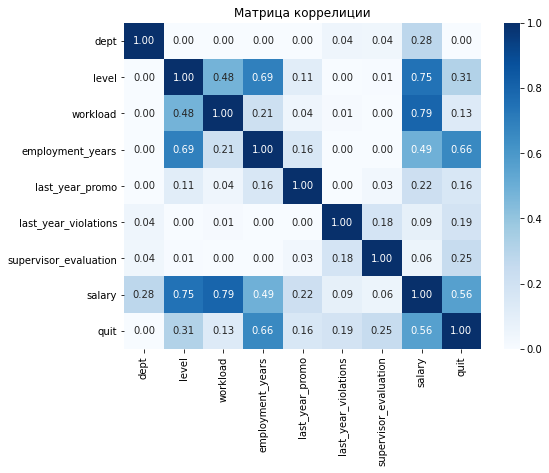

In [73]:
#определяю столбцес с интервальными данными
train_quit_df_no_id_interval_cols = ['salary']

#вычисляю матрицу фи-корреляции
train_quit_df_no_id_phik = train_quit_df_no_id.phik_matrix(interval_cols=train_quit_df_no_id_interval_cols)

#визуализирую матрицу с помощью тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(train_quit_df_no_id_phik, annot=True, cmap='Blues', fmt='.2f')
plt.title("Матрица коррелиции")
plt.show()

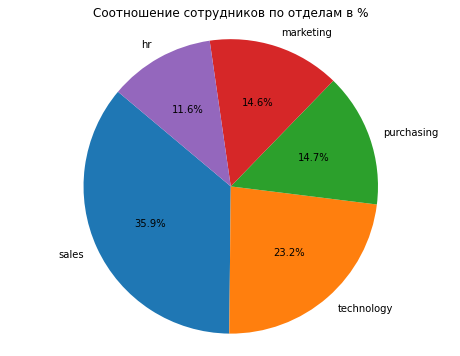

sales         0.3595
technology    0.2320
purchasing    0.1470
marketing     0.1455
hr            0.1160
Name: dept, dtype: float64

In [74]:
#вычисляю количество сотрудников по отделам
train_quit_dept_counts = train_quit_df_no_id.dept.value_counts()

#создаю круговую диаграмму 
plt.figure(figsize=(8, 6))
plt.pie(train_quit_dept_counts, labels=train_quit_dept_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Соотношение сотрудников по отделам в %')
plt.show()

#вычисляю относительные частоты сотрудников по отделам
relative_freq_dept = train_quit_df_no_id['dept'].value_counts(normalize=True)
display(relative_freq_dept)

In [75]:
train_quit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [76]:
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   level                  2000 non-null   object
 1   dept                   2000 non-null   object
 2   id                     2000 non-null   int64 
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   object
 8   salary                 2000 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 140.8+ KB


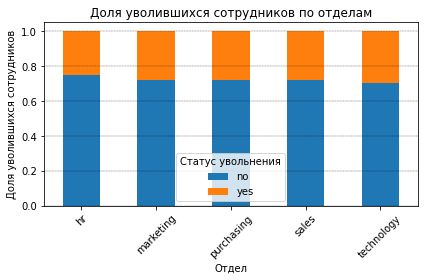

In [77]:
#анализ отдела
quit_by_dept = train_quit_df.groupby('dept')['quit'].value_counts(normalize=True).unstack()
quit_by_dept_sorted = quit_by_dept.sort_values(by='no', ascending=False)

#построение графика
quit_by_dept_sorted.plot(kind='bar', stacked=True)
plt.title('Доля уволившихся сотрудников по отделам')
plt.xlabel('Отдел')
plt.ylabel('Доля уволившихся сотрудников')
plt.xticks(rotation=45)
plt.legend(title='Статус увольнения')
plt.tight_layout()
plt.grid(True, axis='y', color='black', linestyle='--', linewidth=0.3)
plt.show()

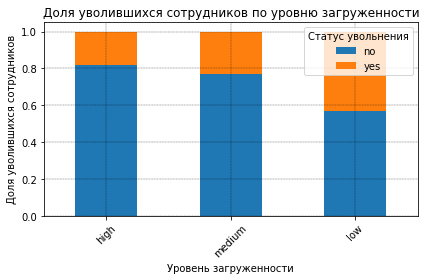

In [78]:
#анализ уровня загруженности
quit_by_workload = train_quit_df.groupby('workload')['quit'].value_counts(normalize=True).unstack()
quit_by_workload_sorted = quit_by_workload.sort_values('no', ascending=False)

#построение графика
quit_by_workload_sorted.plot(kind='bar', stacked=True)
plt.title('Доля уволившихся сотрудников по уровню загруженности')
plt.xlabel('Уровень загруженности')
plt.ylabel('Доля уволившихся сотрудников')
plt.xticks(rotation=45)
plt.legend(title='Статус увольнения')
plt.tight_layout()
plt.grid(True, color='black', linestyle='--', linewidth=0.3)
plt.show()

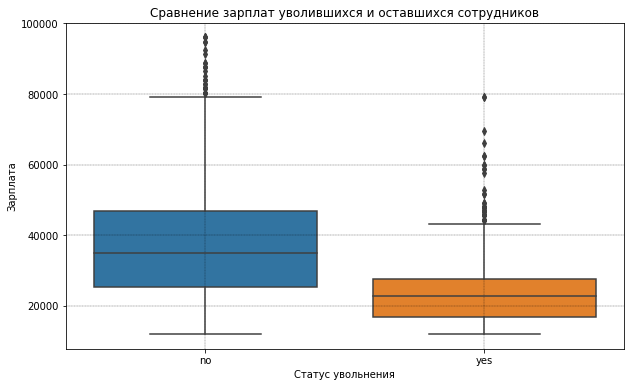

In [79]:
#график сравнение зарплат
plt.figure(figsize=(10, 6))
sns.boxplot(x='quit', y='salary', data=train_quit_df)
plt.title('Сравнение зарплат уволившихся и оставшихся сотрудников')
plt.xlabel('Статус увольнения')
plt.ylabel('Зарплата')
plt.grid(True, color='black', linestyle='--', linewidth=0.3)
plt.show()

In [80]:
#расчет среднего значения зарплаты для уволившихся и не уволившихся сотрудников
average_salary_by_quit = train_quit_df.groupby('quit')['salary'].mean()
display(average_salary_by_quit)

quit
no     37702.228412
yes    23885.106383
Name: salary, dtype: float64

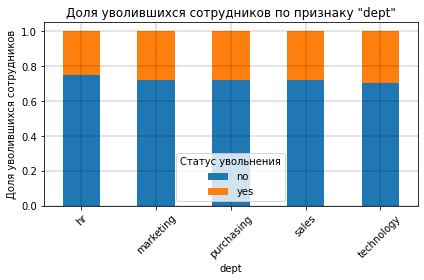

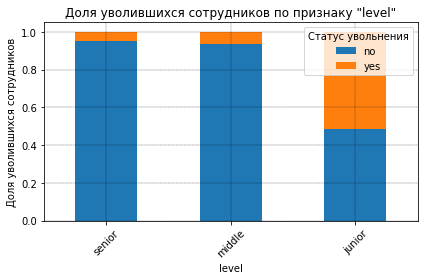

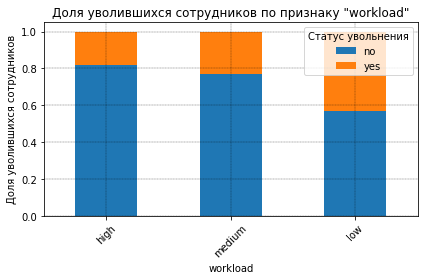

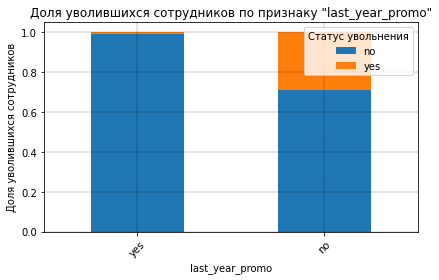

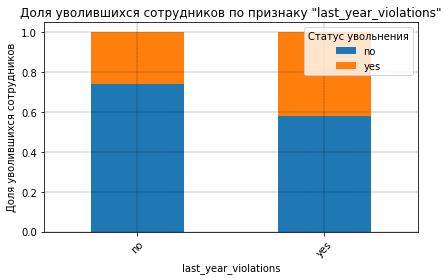

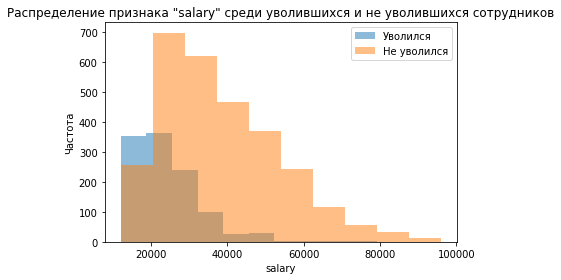

In [81]:
columns_to_analyze = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'salary']

for column in columns_to_analyze:
    if train_quit_df_no_id[column].dtype == 'object':
        quit_by_column = train_quit_df_no_id.groupby(column)['quit'].value_counts(normalize=True).unstack()
        quit_by_column_sorted = quit_by_column.sort_values('no', ascending=False)

        quit_by_column_sorted.plot(kind='bar', stacked=True)
        plt.title(f'Доля уволившихся сотрудников по признаку "{column}"')
        plt.xlabel(column)
        plt.ylabel('Доля уволившихся сотрудников')
        plt.xticks(rotation=45)
        plt.legend(title='Статус увольнения')
        plt.tight_layout()
        plt.grid(True, color='black', linestyle='--', linewidth=0.3)
        plt.show()
        
    else:  
        plt.hist(train_quit_df_no_id[train_quit_df_no_id['quit'] == 'yes'][column], alpha=0.5, label='Уволился')
        plt.hist(train_quit_df_no_id[train_quit_df_no_id['quit'] == 'no'][column], alpha=0.5, label='Не уволился')
        plt.title(f'Распределение признака "{column}" среди уволившихся и не уволившихся сотрудников')
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

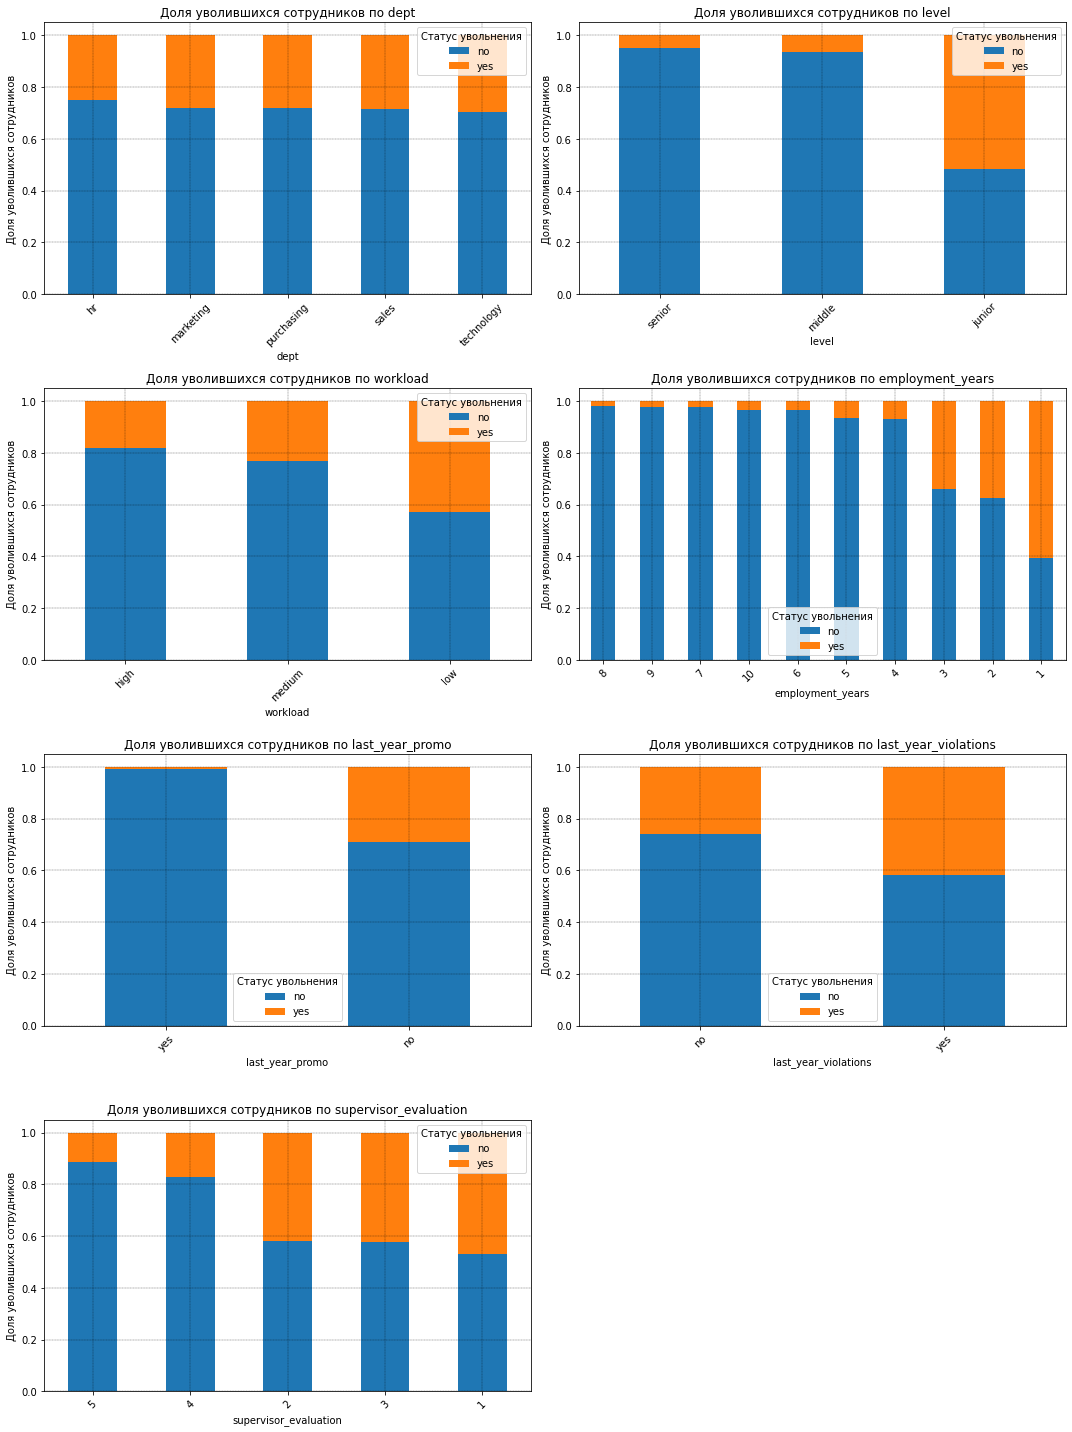

In [82]:
columns_to_plot = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 
                   'last_year_violations', 'supervisor_evaluation']


#расчет количества строк для сетки графиков
num_rows = (len(columns_to_plot) + 1) // 2  
#создание сетки графиков
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))


for i, column in enumerate(columns_to_plot):
    row = i // 2
    col = i % 2
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    quit_by_column = train_quit_df_no_id.groupby(column)['quit'].value_counts(normalize=True).unstack()
    quit_by_column_sorted = quit_by_column.sort_values('no', ascending=False)
    quit_by_column_sorted.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_title(f'Доля уволившихся сотрудников по {column}')
    ax.set_xlabel(f'{column}')
    ax.set_ylabel('Доля уволившихся сотрудников')
    ax.legend(title='Статус увольнения')
    ax.grid(True, color='black', linestyle='--', linewidth=0.3)
    ax.tick_params(axis='x', rotation=45)

if len(columns_to_plot) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

In [83]:
train_quit_df_no_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 281.4+ KB


In [84]:
#удаление столбцов employment_years и supervisor_evaluation из датафрейма 
no_discrete_train_quit_df = train_quit_df_no_id.drop(
    columns=(
        ['employment_years', 'supervisor_evaluation']
    )
)

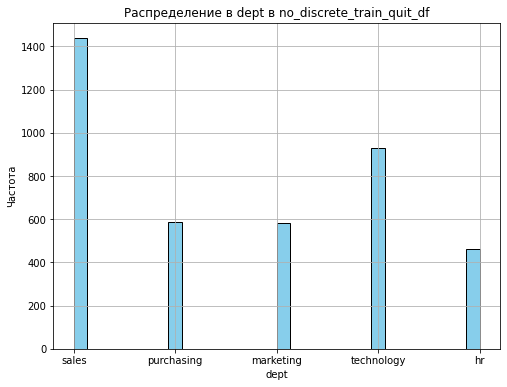

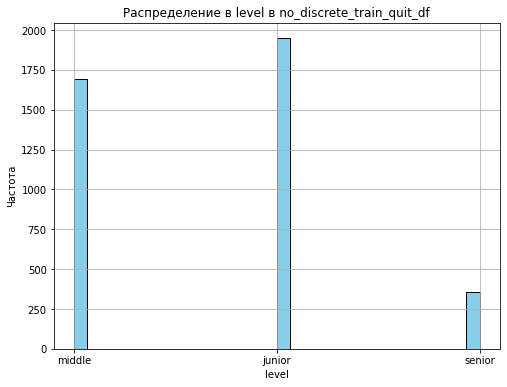

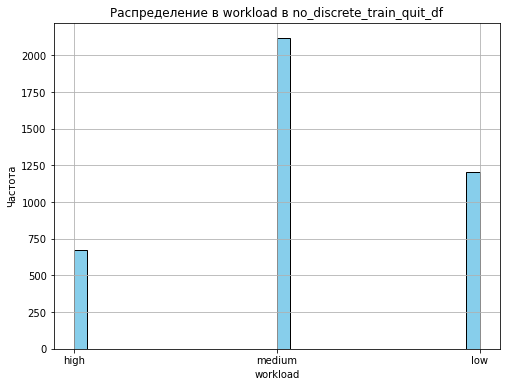

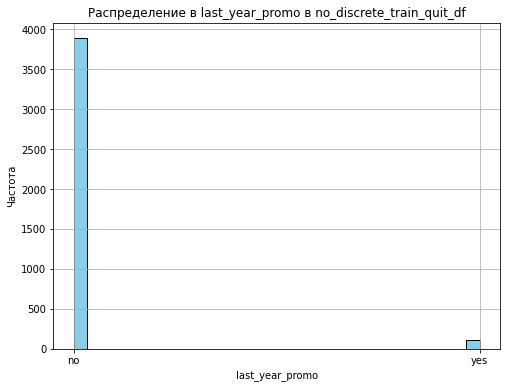

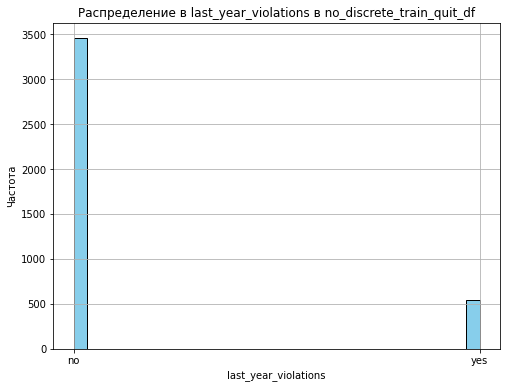

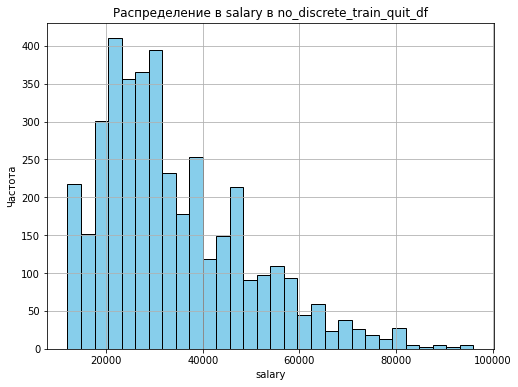

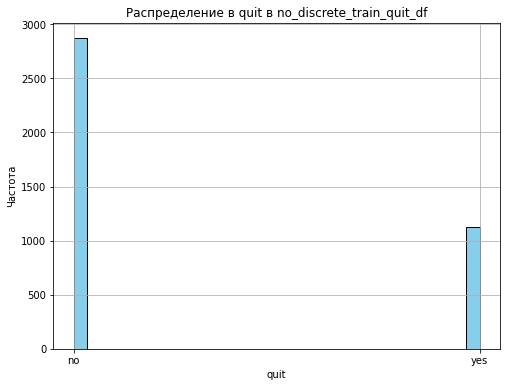

In [85]:
for column in no_discrete_train_quit_df.columns:
    plot_histogram(no_discrete_train_quit_df, column, 'no_discrete_train_quit_df')

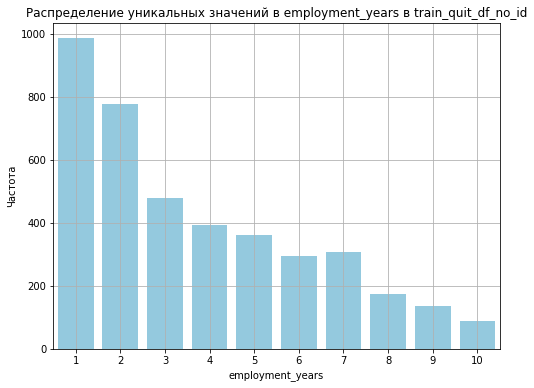

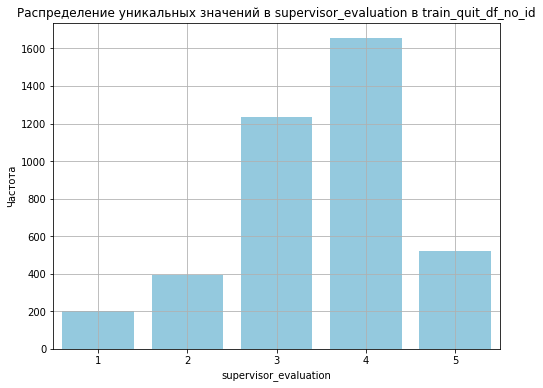

In [86]:
discrete_train_quit_df_no_id = ['employment_years', 'supervisor_evaluation']
plot_countplot(train_quit_df_no_id, discrete_train_quit_df_no_id, 'train_quit_df_no_id')


In [87]:
#объединю датафреймы
features_target_sat_merged = test_features_df.merge(test_target, on='id', how='inner')
feat_job_merged = features_target_sat_merged.merge(test_target_df, on='id', how='inner')
feat_job_merged.head(3)

,level,dept,id,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,junior,marketing,485046,medium,2,no,no,5,28800,0.79,no
1,junior,hr,686555,medium,1,no,no,4,30000,0.72,no
2,middle,sales,467458,low,5,no,no,4,19200,0.64,no


In [88]:
feat_job_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   level                  2000 non-null   object 
 1   dept                   2000 non-null   object 
 2   id                     2000 non-null   int64  
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   object 
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 187.5+ KB


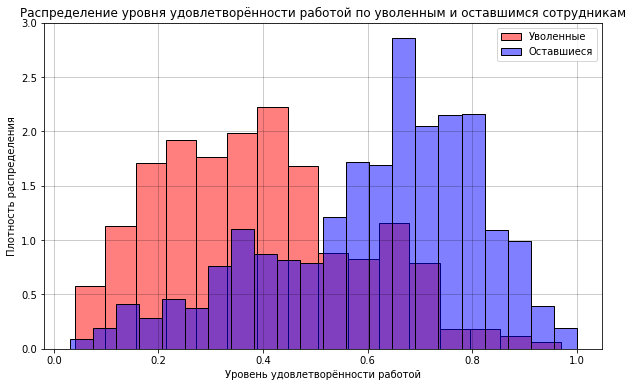

In [89]:
#выбираю сотрудников, которые уволились
quit_yes_histplot = feat_job_merged[feat_job_merged.quit == 'yes']['job_satisfaction_rate']
#оставшиеся сотрудники
quit_no_histplot = feat_job_merged[feat_job_merged.quit == 'no']['job_satisfaction_rate']

#строю гистограмму
plt.figure(figsize=(10, 6))
sns.histplot(quit_yes_histplot, color='red', alpha=0.5, label='Уволенные', stat='density', common_norm=False)
sns.histplot(quit_no_histplot, color='blue', alpha=0.5, label='Оставшиеся', stat='density', common_norm=False)
plt.xlabel('Уровень удовлетворённости работой')
plt.ylabel('Плотность распределения')
plt.title('Распределение уровня удовлетворённости работой по уволенным и оставшимся сотрудникам')
plt.legend()
plt.grid(True, color='black', linestyle='-', linewidth=0.5, alpha=0.4)
plt.show()


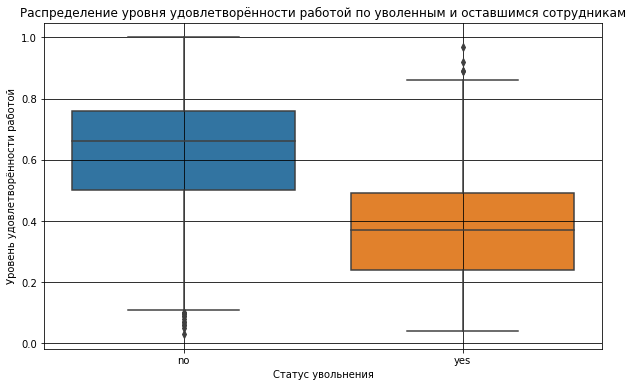

In [90]:
#построение ящиков с усами
plt.figure(figsize=(10, 6))
sns.boxplot(x='quit', y='job_satisfaction_rate', data=feat_job_merged)
plt.xlabel('Статус увольнения')
plt.ylabel('Уровень удовлетворённости работой')
plt.title('Распределение уровня удовлетворённости работой по уволенным и оставшимся сотрудникам')
plt.grid(True, color='black', linestyle='-')
plt.show()

Вывод шага:

В датафрейме train_quit_df все столбцы,кроме id, прошли корреляционный анализ, мультиколлинеарности нет. Я построила круговую диаграмма на основе данных из датафрейма, отображая процентное соотношение количества сотрудников по отделам. Была построена столбчатая диаграмма, которая отображает процентное соотношение количества уволившихся и оставшихся сотрудников в различных отделах компании. Была построена столбчатая диаграмма, отражающая процентное соотношение количества уволившихся и оставшихся сотрудников в зависимости от уровня загруженности. Наибольшее количество увольнений отмечено при уровне low (низком) загруженности, в то время как уровни medium и high имеют более низкий процент увольнений. Был построен ящик с усами для сравнения зарплат уволившихся и оставшихся сотрудников. Визуализация позволяет оценить различия в распределении зарплат между этими двумя группами сотрудников.

Исходя из анализа графика распределения в датафрейме train_quit_df_no_id, были выявлены следующие данные:
Отдел с наибольшим числом сотрудников - sales;
Наиболее распространённый уровень сотрудников - junior;
Наиболее часто встречаемый уровень нагрузки - medium;
За последний год повышение получили около 100 сотрудников из почти 4000;
Более 550 сотрудников из 4000 нарушили трудовой договор за последний год;
Распределение зарплаты имеет нормальную форму, с асимметрией влево;
Количество увольнений сотрудников компании составило более 1100 из 4000.
В столбце employment_years наибольшее количество сотрудников отработало 1 год, а наименьшее количество — 10 лет. 
В столбце supervisor_evaluation наиболее часто встречается оценка 4, что указывает на высокую оценку качества работы сотрудников.

Было выполнено объединение данных из тестового датасета test_features_df, содержащего признаки, с данными оценки удовлетворенности работой и данными о том, уволился ли сотрудник , с использованием внутреннего объединения по идентификатору id. В результате получен объединенный датафрейм feat_job_merged, содержащий информацию о признаках, оценке удовлетворенности работой и статусе увольнения для первых трех наблюдений.

Была построена гистограмма, отображающая распределение уровня удовлетворенности работой среди уволенных и оставшихся сотрудников. На оси x отложен уровень удовлетворенности работой, а на оси y - частота. Гистограммы для уволенных и оставшихся сотрудников наложены друг на друга для наглядного сравнения.

Были построены ящики с усами, отображающие распределение уровня удовлетворенности работой среди уволенных и оставшихся сотрудников. На графике по оси x указан статус увольнения, а по оси y - уровень удовлетворенности работой. Ящики представляют собой интерквартильные диапазоны, а усы отображают весь разброс данных за исключением выбросов.

Сводный портрет сотрудника с высокой вероятностью увольнения:

	•	Отдел: sales
	•	Уровень загруженности: low
	•	Уровень сотрудника: junior
	•	Повышение за последний год: Не получал повышение
	•	Нарушение трудового договора: Нарушал трудовой договор
	•	Зарплата: Ниже среднего уровня
	•	Количество отработанных лет: 1 год
	•	Оценка супервизора: Ниже 4
	•	Уровень удовлетворенности работой: Низкий

Заключение

Этот портрет сотрудника основан на выявленных данных и закономерностях. Для более точного предсказания можно использовать построенную модель, которая может оценивать вероятность увольнения на основе всех рассмотренных признаков.

##### Добавление нового входного признака

Допустим, job_satisfaction_rate и quit действительно связаны и вы получили необходимое значение метрики в первой задаче. Тогда добавьте job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [91]:
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   level                  2000 non-null   object
 1   dept                   2000 non-null   object
 2   id                     2000 non-null   int64 
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   object
 8   salary                 2000 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 140.8+ KB


In [92]:
#отображу размерность выходных данных
pred_train_job = best_model.predict(X_train)
pred_train_job.shape

(4000,)

In [93]:
#предсказание значения job_satisfaction_rate для второй задачи
predicted_job_satisfaction_rate = tree_random_search.best_estimator_.predict(X_test)
print(predicted_job_satisfaction_rate.shape)

(2000,)


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [94]:
#использую функцию
def pred_job_to_test_feat(df, predicted_values, column_name='pred_job_sat_rate'):
    if column_name in df.columns:
        print(f"Столбец '{column_name}' уже существует в датафрейме.")
    else:
        df[column_name] = predicted_values
        print(f"Столбец '{column_name}' добавлен в датафрейм.")
    return df

# Добавление предсказанных значений в датафреймы
test_features_df = pred_job_to_test_feat(test_features, predicted_job_satisfaction_rate)
test_features_df.info()

train_quit_df = pred_job_to_test_feat(train_quit_df, pred_train_job)
train_quit_df.info()

Столбец 'pred_job_sat_rate' добавлен в датафрейм.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   pred_job_sat_rate      2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB
Столбец 'pred_job_sat_rate' добавлен в датафрейм.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns)

In [95]:
# Функция для добавления столбца 'quit' в датафрейм
def test_quit_df(df, other_df, on='id', how='inner'):
    quit_columns = ['quit', 'quit_y', 'quit_x']
    check_cols = [col for col in quit_columns if col in df.columns]
    if not check_cols:
        test_feat_merged = df.merge(other_df, on=on, how=how)
        print("Столбец 'quit' успешно добавлен")
        # Убедимся, что столбец 'pred_job_sat_rate' остается в объединенном датафрейме
        if 'pred_job_sat_rate' in df.columns:
            test_feat_merged['pred_job_sat_rate'] = df['pred_job_sat_rate']
        return test_feat_merged
    else:
        print("Найден столбец 'quit'")
        return df

# Применение функции test_quit_df
test_features_df = test_quit_df(test_features_df, test_target_df)
test_features_df.info()

Столбец 'quit' успешно добавлен
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   pred_job_sat_rate      2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 187.5+ KB


In [96]:
def check_and_add_quit_to_test_df(df, other_df, on='id', how='inner'):
    quit_columns = ['quit', 'quit_y', 'quit_x']
    check_cols = [col for col in quit_columns if col in df.columns]
    if not check_cols:
        test_feat_merged = df.merge(other_df, on=on, how=how)
        print("Столбец quit успешно добавлен")
        print()
        return test_feat_merged
    else:
        print("ВНИМАНИЕ!!! Найден столбец quit")
        print()
        return df   

test_features_df = check_and_add_quit_to_test_df(test_features_df, test_target_df)
test_features_df.info()

ВНИМАНИЕ!!! Найден столбец quit

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   pred_job_sat_rate      2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 187.5+ KB


In [97]:
#преобразую тип данных столбца supervisor_evaluation
test_features_df.supervisor_evaluation = test_features_df.supervisor_evaluation.astype(int)
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   pred_job_sat_rate      2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 187.5+ KB


Вывод:

Столбец job_sat_best_tree_pred с предсказанными значениями лучшей модели из первого задания был успешно добавлен в датафрейм test_features_df.

test_features_df был объединен с test_target_df по столбцу id с использованием внутреннего соединения.

##### Подготовка данных

Подготовьте признаки так же, как и в первой задаче: выполните подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

In [98]:
#разделю данные на обучающие и тестовые
X_train_quit = train_quit_df.drop(['quit'], axis=1)
y_train_quit = train_quit_df['quit']

X_test_quit = test_features_df.drop(['quit'], axis=1)
y_test_quit = test_features_df['quit']

In [99]:
#создание. применение LabelEncoder
label_encoder_quit = LabelEncoder()

y_train_quit = label_encoder_quit.fit_transform(y_train_quit)
y_test_quit = label_encoder_quit.transform(y_test_quit)

In [100]:
ohe_columns_2 = ['dept',
                 'last_year_promo',
                 'last_year_violations']

ord_columns_2 = ['level', 'workload']

num_columns_2 = ['employment_years',
                 'supervisor_evaluation',
                 'salary',
                 'pred_job_sat_rate'
]

In [101]:

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_columns_2),
        ('ord', OrdinalEncoder(
            categories=[
                ['junior', 'middle', 'senior'],
                ['low', 'medium', 'high']
            ], handle_unknown='use_encoded_value', unknown_value=np.nan), ord_columns_2),
        ('num', StandardScaler(), num_columns_2),
    ],
    remainder='passthrough'
)

In [102]:
#создание пайплайна
pipeline_2 = Pipeline(steps=[
    ('preprocessor_2', preprocessor_2),
    ('model_2', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Вывод:

Данные были разделены на тренировочные и тестовые, где X_train_quit и X_test_quit содержат признаки, а y_train_quit и y_test_quit - целевую переменную quit.

Были созданы преобразователи для различных типов признаков с помощью ColumnTransformer. Категориальные признаки были закодированы с использованием методов OneHotEncoder и OrdinalEncoder, в то время как числовые признаки были масштабированы с помощью StandardScaler. Все остальные признаки остались без изменений.

Был создан пайплайн pipeline_2

##### Обучение модели

Обучите как минимум три модели. Как минимум для двух из них подберите гиперпараметры. Проверьте качество лучшей модели.
Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC 
≥
0.91
≥0.91 на тестовой выборке. Напомним: отбор признаков часто помогает улучшить метрику.

In [103]:
param_grids_2 = [
    {
        'model_2': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model_2__max_depth': range(2, 30),
        'model_2__min_samples_split': range(2, 20),
        'model_2__min_samples_leaf': range(2, 20),
        'preprocessor_2__num': [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            'passthrough']
    },
    {
        'model_2': [KNeighborsClassifier()],
        'model_2__n_neighbors': range(2, 20),
        'preprocessor_2__num': [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            'passthrough']
    },
      {
        'model_2': [SVC(kernel='linear', random_state=RANDOM_STATE, probability=True)],
        'model_2__C': [0.1, 1, 10, 100],
        'preprocessor_2__num': [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            'passthrough']
    }
]

In [104]:
model_2 = RandomizedSearchCV(
    pipeline_2,
    param_grids_2,
    cv=5,
    n_iter=10,
    scoring='roc_auc',
    error_score='raise',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

In [105]:
#обучение RandomizedSearchCV
model_2.fit(X_train_quit, y_train_quit)

#вывод результатов оценки каждой модели
results_df = pd.DataFrame(model_2.cv_results_)
print("Результаты оценки каждой модели:")
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

#вывод лучших параметров и метрики для каждой модели
print("Лучшие параметры для модели:")
print(model_2.best_params_)
print()

print("Лучшая метрика (ROC AUC) для модели:")
print(model_2.best_score_)

Результаты оценки каждой модели:
                                              params  mean_test_score  \
0  {'preprocessor_2__num': 'passthrough', 'model_...         0.901725   
1  {'preprocessor_2__num': StandardScaler(), 'mod...         0.874711   
2  {'preprocessor_2__num': StandardScaler(), 'mod...         0.918572   
3  {'preprocessor_2__num': MinMaxScaler(), 'model...         0.922767   
4  {'preprocessor_2__num': RobustScaler(), 'model...         0.862924   
5  {'preprocessor_2__num': RobustScaler(), 'model...         0.922384   
6  {'preprocessor_2__num': 'passthrough', 'model_...         0.908496   
7  {'preprocessor_2__num': MinMaxScaler(), 'model...         0.897195   
8  {'preprocessor_2__num': MinMaxScaler(), 'model...         0.874711   
9  {'preprocessor_2__num': MinMaxScaler(), 'model...         0.897195   

   std_test_score  rank_test_score  
0        0.013110                5  
1        0.010743                8  
2        0.007847                3  
3        0.0102

In [106]:
probabilities = model_2.predict_proba(X_test_quit)
probab_one = probabilities[:, 1]
roc_auc = roc_auc_score(y_test_quit, probab_one)
if roc_auc > 0.91:
    print('Метрика лучшей модели на тренировочной выборке:', model_2.best_score_)
    print('ROC-кривая лучшей модели: ', roc_auc)
else:
    print("Ошибка")
    print()
    print('ROC_AUC :', roc_auc)

Метрика лучшей модели на тренировочной выборке: 0.9227674009703545
ROC-кривая лучшей модели:  0.9171587002904049


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [107]:
X_test_quit.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'pred_job_sat_rate'],
      dtype='object')

Вывод шага:

Были определены три модели: DecisionTreeClassifier, KNeighborsClassifier и SVC с параметром probability=True, что позволяет получать вероятности принадлежности к классам.
Были определены сетки параметров для подбора гиперпараметров каждой модели.
На этом этапе проекта были проведены следующие операции: подбор гиперпараметров для моделей Random Forest Classifier и SVM с использованием RandomizedSearchCV, обучение моделей на тренировочных данных, оценка их производительности на тестовой выборке и вычисление метрики ROC-AUC для каждой модели. По результатам анализа, лучшей моделью была выбрана RandomForestClassifier(), демонстрирующая ROC-AUC 0.9171543787905727.

##### Общий вывод:

- Шаг загрузки данных:

мпортированы необходимые библиотеки для выполнения задачи.

Файл train_job_satisfaction_rate.csv был успешно загружен и сохранен как train_job.
Файл test_target_job_satisfaction_rate.csv был успешно загружен и сохранен как test_target.

- Шаг предобработки данных:

- В датафрейме train_quit_df пропущенных значений типа NaN не обнаружено. Значения sinior были изменены на senior

- В датафрейме test_target_df пропущенных значений типа NaN не обнаружено

- Шаг иследовательского анализа данных:

 датафрейме train_quit_df все столбцы,кроме id, прошли корреляционный анализ, мультиколлинеарности нет. Я построила круговую диаграмма на основе данных из датафрейма, отображая процентное соотношение количества сотрудников по отделам. Была построена столбчатая диаграмма, которая отображает процентное соотношение количества уволившихся и оставшихся сотрудников в различных отделах компании. Была построена столбчатая диаграмма, отражающая процентное соотношение количества уволившихся и оставшихся сотрудников в зависимости от уровня загруженности. Наибольшее количество увольнений отмечено при уровне low (низком) загруженности, в то время как уровни medium и high имеют более низкий процент увольнений. Был построен ящик с усами для сравнения зарплат уволившихся и оставшихся сотрудников. Визуализация позволяет оценить различия в распределении зарплат между этими двумя группами сотрудников.

Исходя из анализа графика распределения в датафрейме train_quit_df_no_id, были выявлены следующие данные: Отдел с наибольшим числом сотрудников - sales; Наиболее распространённый уровень сотрудников - junior; Наиболее часто встречаемый уровень нагрузки - medium; За последний год повышение получили около 100 сотрудников из почти 4000; Более 550 сотрудников из 4000 нарушили трудовой договор за последний год; Распределение зарплаты имеет нормальную форму, с асимметрией влево; Количество увольнений сотрудников компании составило более 1100 из 4000. В столбце employment_years наибольшее количество сотрудников отработало 1 год, а наименьшее количество — 10 лет. В столбце supervisor_evaluation наиболее часто встречается оценка 4, что указывает на высокую оценку качества работы сотрудников.

Было выполнено объединение данных из тестового датасета test_features_df, содержащего признаки, с данными оценки удовлетворенности работой и данными о том, уволился ли сотрудник , с использованием внутреннего объединения по идентификатору id. В результате получен объединенный датафрейм feat_job_merged, содержащий информацию о признаках, оценке удовлетворенности работой и статусе увольнения для первых трех наблюдений.

Была построена гистограмма, отображающая распределение уровня удовлетворенности работой среди уволенных и оставшихся сотрудников. На оси x отложен уровень удовлетворенности работой, а на оси y - частота. Гистограммы для уволенных и оставшихся сотрудников наложены друг на друга для наглядного сравнения.

Были построены ящики с усами, отображающие распределение уровня удовлетворенности работой среди уволенных и оставшихся сотрудников. На графике по оси x указан статус увольнения, а по оси y - уровень удовлетворенности работой. Ящики представляют собой интерквартильные диапазоны, а усы отображают весь разброс данных за исключением выбросов.

- Шаг подготовки данных

Данные были разделены на тренировочные и тестовые, где X_train_quit и X_test_quit содержат признаки, а y_train_quit и y_test_quit - целевую переменную quit.

Были созданы преобразователи для различных типов признаков с помощью ColumnTransformer. Категориальные признаки были закодированы с использованием методов OneHotEncoder и OrdinalEncoder, в то время как числовые признаки были масштабированы с помощью StandardScaler. Все остальные признаки остались без изменений.

Был создан пайплайн pipeline_2

- Шаг обучения модели:

Были определены три модели: DecisionTreeClassifier, KNeighborsClassifier и SVC с параметром probability=True, что позволяет получать вероятности принадлежности к классам. Были определены сетки параметров для подбора гиперпараметров каждой модели. На этом этапе проекта были проведены следующие операции: подбор гиперпараметров для моделей Random Forest Classifier и SVM с использованием RandomizedSearchCV, обучение моделей на тренировочных данных, оценка их производительности на тестовой выборке и вычисление метрики ROC-AUC для каждой модели. По результатам анализа, лучшей моделью была выбрана RandomForestClassifier(), демонстрирующая ROC-AUC 0.9171543787905727.


#### Итоговый вывод

Исходя из анализа данных о увольнениях сотрудников, можно предложить следующие рекомендации для бизнеса:
    - Анализ причин увольнений.
    - Улучшение условий труда.
    - Обучение и развитие персонала.
    - Улучшить систему мотивации.

Провести более детальный анализ причин увольнений, особенно в отделах sales и technology, где наблюдается наибольшее количество увольнений. Это может включать интервьюирование уволившихся сотрудников, анализ обратной связи и опрос сотрудников, чтобы выявить факторы, влияющие на их решение уйти.
Обратить внимание на факторы, связанные с уровнем удовлетворенности работой. Также, можно провести опросы сотрудников и оценить, что является наоболее важным аспектом в их работе, и внести соответствующие изменения для улучшения рабочей среды.
Инвестировать в обучение и развитие сотрудников, особенно тех, кто отработал более 1 года и показывает потенциал для карьерного роста. Предложить программы обучения, наставничество и развивающие возможности, чтобы помочь сотрудникам достичь своих карьерных целей внутри компании.
Мониторинг уровня загрузки и мотивация сотрудников: Внимательное отслеживание уровня загрузки сотрудников и реагирование на признаки истощения или перегрузки работой. Обеспечения справедливого распределения нагрузки и стимулирулирование сотрудников мотивационными программами и поощрениями за достижение результатов.
Пересмотреть систему премирования и поощрений, чтобы она была более прозрачной, справедливой и мотивирующей для сотрудников. Рассмотреть внедрение системы вознаграждений за достижение целей и успешное выполнение задач.

Эти рекомендации могут помочь компании снизить уровень увольнений, повысить удовлетворенность сотрудников и создать благоприятную рабочую атмосферу, способствующую росту бизнеса.